# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1)
  * [5.2 Introduction](#5.2)
  * [5.3 Imports](#5.3)
  * [5.4 Load Data](#5.4)
  * [5.5 Initial model - Random Forest Regression](#5.5)
  * [5.6 Trimming features](#5.6)
      - [5.6.1 drop features by 25% percentile importance](#5.6.1)
      - [5.6.2 drop features by 50% percentile importance](#5.6.2)
  * [5.7 Model comparison](#5.7)
      - [5.7.1 Logistic Regression](#5.7.1)
      - [5.7.2 Lasso Regression](#5.7.2)
      - [5.7.3 Ridge Regression](#5.7.3)
      - [5.7.4 Bayesian Ridge Regression](#5.7.4)
      - [5.7.5 Kernel Ridge Regression](#5.7.5)
      - [5.7.6 Gradient Boosting Regression](#5.7.6)
      - [5.7.7 Support Vector Machine](#5.7.7)
      - [5.7.8 Stochastic Gradient Descent Regression](#5.7.8)
      - [5.7.9 Elastic Net Regression](#5.7.9)
      - [5.7.10 LGBM Regression](#5.7.10)
      - [5.7.11 XGBoost Regression](#5.7.11)
      - [5.7.12 CatBoost Regression](#5.7.12)
      - [5.7.13 Best model](#5.7.13)
  * [5.8 Hyperparameter Tuning](#5.8) 
      - [5.8.1 Grid Search](#5.8.1)
      - [5.8.2 Randomized Search](#5.8.2)
  * [5.9  Refit Model On All Available Data](#5.9)
  * [5.10 Selective modeling](#5.10)
  * [5.10 Summary](#5.11)
  


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we continue to select best models. 
- First, preprocessing and training indicate that part of features are not contributing to training models. Therefore, the less important features will be removed. 
- Only linear regression and random forest regression are tested in previous section. One more models will be tried as a comparison. 
- As for metrics, we still use r2 score as the main metric. 

## 5.3 Imports<a id='5.3_Imports'></a>

In [8]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
import datetime

from library.sb_utils import save_file

## 5.4 Load Data<a id='5.4'></a>

In [9]:
student_data = pd.read_csv('../data/student_data_cleaned.csv')
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [10]:
col_info = pd.read_csv('../data/data_columns.csv')
col_info['dtype'] = student_data.dtypes.values
col_info

,order,name,meaning,notes,dtype
0,1,school,student's school,binary: 'GP' - Gabriel Pereira or 'MS' - Mousi...,object
1,2,sex,student's sex,binary: 'F' - female or 'M' - male,object
2,3,age,student's age,numeric: from 15 to 22,int64
3,4,address,student's home address type,binary: 'U' - urban or 'R' - rural,object
4,5,famsize,family size,binary: 'LE3' - less or equal to 3 or 'GT3' - ...,object
5,6,Pstatus,parent's cohabitation status,binary: 'T' - living together or 'A' - apart,object
6,7,Medu,mother's education,"numeric: 0 - none, 1 - primary education 4th g...",int64
7,8,Fedu,father's education,"numeric: 0 - none, 1 - primary education 4th g...",int64
8,9,Mjob,mother's job,"nominal: 'teacher', 'health' care related, civ...",object
9,10,Fjob,father's job,"nominal: 'teacher', 'health' care related, civ...",object


## 5.5 Initial model - Random Forest Regression<a id='5.5'></a>

We repeat the random forest model from previous steps below. 

In [11]:
data_dummies = pd.get_dummies(student_data)

# decode the categorical features.
X = data_dummies.drop(columns = ['G1','G2','G3'])
y = data_dummies['G3']

# we split the train and test set by 0.75/0.25.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use random forest model to train all features
RF = RandomForestRegressor(n_estimators=100, random_state=47)
RF.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(RF.score(X_train_scaled, y_train),3))
y_pred = RF.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
rf_cv_results = cross_validate(RF, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_cv_scores = rf_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(rf_cv_scores),3))

The r2 score for the training data is  0.884
The r2 score for the test data is  0.132
The cv score mean is  0.139 
 The cv score std is  0.14


## 5.6 Trimming features<a id='5.6'></a>

First, we import the importance of features generated by the random forest model in previous notebook.

In [12]:
feature_importance = pd.read_csv('../data/feature importance.csv')
feature_importance.columns=['feature', 'importance']
feature_importance.describe()

,importance
count,56.000000
mean,0.017857
std,0.019012
min,0.000597
25%,0.006534
50%,0.009083
75%,0.027462
max,0.097954


### 5.6.1 drop features by 25% percentile importance<a id='5.6.1'></a>

First, we use the 25% percentile as the criterion to trim the features. it means that all features with importance less than 0.0066 is dropped. 

In [13]:
less_important_feagture = feature_importance[feature_importance.importance < 0.0066]['feature']
drop_feagture = pd.DataFrame(less_important_feagture.str.split(pat='_').to_list()).iloc[:,0].drop_duplicates().to_list()
print(drop_feagture)

['Fjob', 'guardian', 'internet', 'nursery', 'Pstatus', 'school', 'higher']


In [14]:
# check the change in number of features before and after the dropping
student_data_trimmed = student_data.drop(columns=drop_feagture)
print(student_data.shape, student_data_trimmed.shape)

(357, 33) (357, 26)


It can be seen that 7 features have been dropped from the student_data. 

Next step, the trimmed student data will be reprocessed and scaled as before.

In [15]:
data_dummies = pd.get_dummies(student_data_trimmed)

# decode the categorical features.
X = data_dummies.drop(columns = ['G1','G2','G3'])
y = data_dummies['G3']

# we split the train and test set by 0.75/0.25.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Use random forest model to train all features
RF = RandomForestRegressor(n_estimators=100, random_state=47)
RF.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(RF.score(X_train_scaled, y_train),3))
y_pred = RF.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
rf_cv_results = cross_validate(RF, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_cv_scores = rf_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(rf_cv_scores),3))

The r2 score for the training data is  0.882
The r2 score for the test data is  0.145
The cv score mean is  0.127 
 The cv score std is  0.131


- The r2 score for the test data is slight improved.
- However, the cross validation shows that dropping features yields an even lower r2 score of 0.127 compared to 0.139 by using all the features. 

### 5.6.2 drop features by 50% percentile importance<a id='5.6.2'></a>

In [17]:
less_important_feagture = feature_importance[feature_importance.importance < 0.01]['feature']
drop_feagture = pd.DataFrame(less_important_feagture.str.split(pat='_').to_list()).iloc[:,0].drop_duplicates().to_list()
print(drop_feagture)
print(len(drop_feagture),'features are dropped due to their low weights on the target values')

['reason', 'address', 'famsup', 'paid', 'Mjob', 'activities', 'Fjob', 'romantic', 'famsize', 'guardian', 'internet', 'nursery', 'Pstatus', 'school', 'higher']
15 features are dropped due to their low weights on the target values


In [18]:
student_data_trimmed = student_data.drop(columns=drop_feagture)

data_dummies = pd.get_dummies(student_data_trimmed)

# decode the categorical features.
X = data_dummies.drop(columns = ['G1','G2','G3'])
y = data_dummies['G3']

# we split the train and test set by 0.75/0.25.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

# standardize the data
# from sklearn.preprocessing import PowerTransformer
# scaler = PowerTransformer()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Use random forest model to train all features
RF = RandomForestRegressor(n_estimators=100, random_state=47)
RF.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(RF.score(X_train_scaled, y_train),3))
y_pred = RF.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
rf_cv_results = cross_validate(RF, X_train_scaled, y_train, cv=10,return_train_score=True)
rf_cv_scores = rf_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(rf_cv_scores),3))

The r2 score for the training data is  0.88
The r2 score for the test data is  0.166
The cv score mean is  0.1 
 The cv score std is  0.156


- By dropping more features, the r2 score for test data is improved again.
- However, the cross validation shows that the r2 score is only 0.1, which could be caused by using less features. 
- In conclusion, dropping features doesn't help with the model performance. We will stick to using all the features for modeling. 

### 5.7 Model comparison<a id='5.7)'></a>

We need to rebuild the X and y variables for model comparison.

In [20]:
data_dummies = pd.get_dummies(student_data)

# decode the categorical features.
X = data_dummies.drop(columns = ['G1','G2','G3'])
y = data_dummies['G3']

# we split the train and test set by 0.75/0.25.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In the model comparison, we only use the defaut hyperparameters of models. 
`The tuning of hyperparameters will be implemented in the next section.`

We alread have the results for Random forest regression as shown below. We will use these two metrics to compare various models.
- The cv score mean is  0.139 
- The cv score std is  0.14

#### 5.7.1 Logistic Regression<a id='5.7.1'></a>

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(lr.score(X_train_scaled, y_train),3))
y_pred = lr.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
lr_cv_results = cross_validate(lr, X_train_scaled, y_train, cv=10,return_train_score=True)
lr_cv_scores = lr_cv_results['test_score']
print('The cv score mean is ', round(np.mean(lr_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(lr_cv_scores),3))

The r2 score for the training data is  0.618
The r2 score for the test data is  -0.488


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


The cv score mean is  0.094 
 The cv score std is  0.042


#### 5.7.2 Lasso Regression<a id='5.7.2'></a>

In [22]:
from sklearn.linear_model import Lasso
ls = Lasso()
ls.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(ls.score(X_train_scaled, y_train),3))
y_pred = ls.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
ls_cv_results = cross_validate(ls, X_train_scaled, y_train, cv=10,return_train_score=True)
ls_cv_scores = ls_cv_results['test_score']
print('The cv score mean is ', round(np.mean(ls_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(ls_cv_scores),3))

The r2 score for the training data is  0.0
The r2 score for the test data is  -0.022
The cv score mean is  -0.037 
 The cv score std is  0.055


#### 5.7.3 Ridge Regression<a id='5.7.3'></a>

In [23]:
from sklearn.linear_model import Ridge
rd = Ridge()
rd.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(rd.score(X_train_scaled, y_train),3))
y_pred = rd.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
rd_cv_results = cross_validate(rd, X_train_scaled, y_train, cv=10,return_train_score=True)
rd_cv_scores = rd_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rd_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(rd_cv_scores),3))

The r2 score for the training data is  0.37
The r2 score for the test data is  0.068
The cv score mean is  0.057 
 The cv score std is  0.227


#### 5.7.4 Bayesian Ridge Regression<a id='5.7.4'></a>

In [24]:
from sklearn.linear_model import BayesianRidge
brd = BayesianRidge()
brd.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(brd.score(X_train_scaled, y_train),3))
y_pred = brd.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
brd_cv_results = cross_validate(brd, X_train_scaled, y_train, cv=10,return_train_score=True)
brd_cv_scores = brd_cv_results['test_score']
print('The cv score mean is ', round(np.mean(brd_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(brd_cv_scores),3))

The r2 score for the training data is  0.332
The r2 score for the test data is  0.14
The cv score mean is  0.144 
 The cv score std is  0.135


#### 5.7.5 Kernel Ridge Regression<a id='5.7.5'></a>

In [25]:
from sklearn.kernel_ridge import KernelRidge
krd = KernelRidge()
krd.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(krd.score(X_train_scaled, y_train),3))
y_pred = krd.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
krd_cv_results = cross_validate(krd, X_train_scaled, y_train, cv=10,return_train_score=True)
krd_cv_scores = krd_cv_results['test_score']
print('The cv score mean is ', round(np.mean(krd_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(krd_cv_scores),3))

The r2 score for the training data is  -11.667
The r2 score for the test data is  -16.089
The cv score mean is  -18.099 
 The cv score std is  3.847


#### 5.7.6 Gradient Boosting Regression<a id='5.7.6'></a>

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(gb.score(X_train_scaled, y_train),3))
y_pred = gb.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
gb_cv_results = cross_validate(gb, X_train_scaled, y_train, cv=10,return_train_score=True)
gb_cv_scores = gb_cv_results['test_score']
print('The cv score mean is ', round(np.mean(gb_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(gb_cv_scores),3))

The r2 score for the training data is  0.796
The r2 score for the test data is  0.105
The cv score mean is  0.037 
 The cv score std is  0.153


#### 5.7.7 Support Vector Machine<a id='5.7.7'></a>

In [27]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(svr.score(X_train_scaled, y_train),3))
y_pred = svr.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
svr_cv_results = cross_validate(svr, X_train_scaled, y_train, cv=10,return_train_score=True)
svr_cv_scores = svr_cv_results['test_score']
print('The cv score mean is ', round(np.mean(svr_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(svr_cv_scores),3))

The r2 score for the training data is  0.439
The r2 score for the test data is  0.08
The cv score mean is  0.136 
 The cv score std is  0.116


#### 5.7.8 Stochastic Gradient Descent Regression<a id='5.7.8'></a>

In [28]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(sgd.score(X_train_scaled, y_train),3))
y_pred = sgd.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
sgd_cv_results = cross_validate(sgd, X_train_scaled, y_train, cv=10,return_train_score=True)
sgd_cv_scores = sgd_cv_results['test_score']
print('The cv score mean is ', round(np.mean(sgd_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(sgd_cv_scores),3))

The r2 score for the training data is  0.37
The r2 score for the test data is  0.063
The cv score mean is  0.051 
 The cv score std is  0.231


#### 5.7.9 Elastic Net Regression<a id='5.7.9'></a>

In [29]:
from sklearn.linear_model import ElasticNet
en = ElasticNet()
en.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(en.score(X_train_scaled, y_train),3))
y_pred = en.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
en_cv_results = cross_validate(en, X_train_scaled, y_train, cv=10,return_train_score=True)
en_cv_scores = en_cv_results['test_score']
print('The cv score mean is ', round(np.mean(en_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(en_cv_scores),3))

The r2 score for the training data is  0.111
The r2 score for the test data is  0.084
The cv score mean is  0.045 
 The cv score std is  0.048


#### 5.7.10 LGBM Regression<a id='5.7.10'></a>

In [30]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(lgbm.score(X_train_scaled, y_train),3))
y_pred = lgbm.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
lgbm_cv_results = cross_validate(lgbm, X_train_scaled, y_train, cv=10,return_train_score=True)
lgbm_cv_scores = lgbm_cv_results['test_score']
print('The cv score mean is ', round(np.mean(lgbm_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(lgbm_cv_scores),3))

The r2 score for the training data is  0.834
The r2 score for the test data is  0.041
The cv score mean is  0.097 
 The cv score std is  0.216


#### 5.7.11 XGBoost Regression<a id='5.7.11'></a>

In [34]:
! pip install CatBoost

Defaulting to user installation because normal site-packages is not writeable


In [35]:
from xgboost.sklearn import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(xgbr.score(X_train_scaled, y_train),3))
y_pred = xgbr.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
xgbr_cv_results = cross_validate(xgbr, X_train_scaled, y_train, cv=10,return_train_score=True)
xgbr_cv_scores = xgbr_cv_results['test_score']
print('The cv score mean is ', round(np.mean(xgbr_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(xgbr_cv_scores),3))

The r2 score for the training data is  1.0
The r2 score for the test data is  -0.049
The cv score mean is  -0.054 
 The cv score std is  0.219


#### 5.7.12 CatBoost Regression<a id='5.7.12'></a>

In [36]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor()
cbr.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(cbr.score(X_train_scaled, y_train),3))
y_pred = cbr.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
cbr_cv_results = cross_validate(cbr, X_train_scaled, y_train, cv=10,return_train_score=True)
cbr_cv_scores = cbr_cv_results['test_score']
print('The cv score mean is ', round(np.mean(cbr_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(cbr_cv_scores),3))

Learning rate set to 0.033233
0:	learn: 3.2702414	total: 144ms	remaining: 2m 23s
1:	learn: 3.2561251	total: 146ms	remaining: 1m 13s
2:	learn: 3.2399681	total: 149ms	remaining: 49.4s
3:	learn: 3.2241289	total: 151ms	remaining: 37.6s
4:	learn: 3.2060894	total: 153ms	remaining: 30.5s
5:	learn: 3.1928241	total: 155ms	remaining: 25.7s
6:	learn: 3.1737770	total: 157ms	remaining: 22.3s
7:	learn: 3.1582941	total: 159ms	remaining: 19.8s
8:	learn: 3.1446155	total: 162ms	remaining: 17.8s
9:	learn: 3.1313141	total: 164ms	remaining: 16.2s
10:	learn: 3.1186830	total: 166ms	remaining: 14.9s
11:	learn: 3.1027253	total: 168ms	remaining: 13.8s
12:	learn: 3.0827270	total: 170ms	remaining: 12.9s
13:	learn: 3.0646538	total: 172ms	remaining: 12.1s
14:	learn: 3.0473686	total: 174ms	remaining: 11.4s
15:	learn: 3.0287846	total: 176ms	remaining: 10.8s
16:	learn: 3.0089917	total: 178ms	remaining: 10.3s
17:	learn: 2.9920457	total: 181ms	remaining: 9.85s
18:	learn: 2.9795220	total: 183ms	remaining: 9.45s
19:	learn

178:	learn: 1.7615020	total: 517ms	remaining: 2.37s
179:	learn: 1.7563584	total: 519ms	remaining: 2.36s
180:	learn: 1.7506337	total: 521ms	remaining: 2.36s
181:	learn: 1.7444064	total: 523ms	remaining: 2.35s
182:	learn: 1.7394052	total: 525ms	remaining: 2.35s
183:	learn: 1.7348149	total: 528ms	remaining: 2.34s
184:	learn: 1.7327260	total: 530ms	remaining: 2.33s
185:	learn: 1.7267236	total: 532ms	remaining: 2.33s
186:	learn: 1.7203976	total: 534ms	remaining: 2.32s
187:	learn: 1.7149085	total: 536ms	remaining: 2.32s
188:	learn: 1.7113123	total: 539ms	remaining: 2.31s
189:	learn: 1.7067644	total: 541ms	remaining: 2.31s
190:	learn: 1.7031372	total: 543ms	remaining: 2.3s
191:	learn: 1.6968278	total: 545ms	remaining: 2.29s
192:	learn: 1.6922176	total: 548ms	remaining: 2.29s
193:	learn: 1.6864325	total: 550ms	remaining: 2.28s
194:	learn: 1.6768204	total: 552ms	remaining: 2.28s
195:	learn: 1.6739931	total: 554ms	remaining: 2.27s
196:	learn: 1.6705887	total: 557ms	remaining: 2.27s
197:	learn: 1

410:	learn: 0.9461278	total: 1.05s	remaining: 1.5s
411:	learn: 0.9458945	total: 1.05s	remaining: 1.5s
412:	learn: 0.9429841	total: 1.05s	remaining: 1.5s
413:	learn: 0.9408085	total: 1.05s	remaining: 1.49s
414:	learn: 0.9392585	total: 1.06s	remaining: 1.49s
415:	learn: 0.9364923	total: 1.06s	remaining: 1.49s
416:	learn: 0.9337956	total: 1.06s	remaining: 1.49s
417:	learn: 0.9311159	total: 1.06s	remaining: 1.48s
418:	learn: 0.9297916	total: 1.07s	remaining: 1.48s
419:	learn: 0.9275867	total: 1.07s	remaining: 1.48s
420:	learn: 0.9269385	total: 1.07s	remaining: 1.47s
421:	learn: 0.9260266	total: 1.07s	remaining: 1.47s
422:	learn: 0.9253052	total: 1.07s	remaining: 1.47s
423:	learn: 0.9233880	total: 1.08s	remaining: 1.46s
424:	learn: 0.9217342	total: 1.08s	remaining: 1.46s
425:	learn: 0.9194551	total: 1.08s	remaining: 1.46s
426:	learn: 0.9187844	total: 1.08s	remaining: 1.46s
427:	learn: 0.9150995	total: 1.09s	remaining: 1.45s
428:	learn: 0.9130533	total: 1.09s	remaining: 1.45s
429:	learn: 0.9

574:	learn: 0.6512122	total: 1.41s	remaining: 1.04s
575:	learn: 0.6490313	total: 1.41s	remaining: 1.04s
576:	learn: 0.6469818	total: 1.41s	remaining: 1.04s
577:	learn: 0.6461434	total: 1.42s	remaining: 1.03s
578:	learn: 0.6444569	total: 1.42s	remaining: 1.03s
579:	learn: 0.6426276	total: 1.42s	remaining: 1.03s
580:	learn: 0.6405744	total: 1.42s	remaining: 1.02s
581:	learn: 0.6382725	total: 1.42s	remaining: 1.02s
582:	learn: 0.6366536	total: 1.43s	remaining: 1.02s
583:	learn: 0.6345616	total: 1.43s	remaining: 1.02s
584:	learn: 0.6328775	total: 1.43s	remaining: 1.01s
585:	learn: 0.6309664	total: 1.43s	remaining: 1.01s
586:	learn: 0.6292927	total: 1.44s	remaining: 1.01s
587:	learn: 0.6284958	total: 1.44s	remaining: 1.01s
588:	learn: 0.6266131	total: 1.44s	remaining: 1s
589:	learn: 0.6254852	total: 1.44s	remaining: 1s
590:	learn: 0.6241567	total: 1.44s	remaining: 999ms
591:	learn: 0.6227178	total: 1.45s	remaining: 996ms
592:	learn: 0.6210125	total: 1.45s	remaining: 994ms
593:	learn: 0.6197

804:	learn: 0.3729905	total: 1.92s	remaining: 464ms
805:	learn: 0.3721961	total: 1.92s	remaining: 462ms
806:	learn: 0.3713836	total: 1.92s	remaining: 459ms
807:	learn: 0.3700708	total: 1.92s	remaining: 457ms
808:	learn: 0.3691184	total: 1.92s	remaining: 454ms
809:	learn: 0.3681872	total: 1.93s	remaining: 452ms
810:	learn: 0.3673837	total: 1.93s	remaining: 450ms
811:	learn: 0.3659398	total: 1.93s	remaining: 447ms
812:	learn: 0.3646465	total: 1.93s	remaining: 445ms
813:	learn: 0.3639670	total: 1.94s	remaining: 442ms
814:	learn: 0.3627281	total: 1.94s	remaining: 440ms
815:	learn: 0.3622001	total: 1.94s	remaining: 438ms
816:	learn: 0.3617028	total: 1.94s	remaining: 435ms
817:	learn: 0.3608610	total: 1.95s	remaining: 433ms
818:	learn: 0.3603044	total: 1.95s	remaining: 431ms
819:	learn: 0.3592890	total: 1.95s	remaining: 428ms
820:	learn: 0.3584205	total: 1.95s	remaining: 426ms
821:	learn: 0.3578029	total: 1.96s	remaining: 424ms
822:	learn: 0.3568934	total: 1.96s	remaining: 421ms
823:	learn: 

969:	learn: 0.2739438	total: 2.27s	remaining: 70.2ms
970:	learn: 0.2729172	total: 2.27s	remaining: 67.8ms
971:	learn: 0.2718372	total: 2.27s	remaining: 65.5ms
972:	learn: 0.2712755	total: 2.27s	remaining: 63.1ms
973:	learn: 0.2701940	total: 2.28s	remaining: 60.8ms
974:	learn: 0.2699035	total: 2.28s	remaining: 58.5ms
975:	learn: 0.2693608	total: 2.28s	remaining: 56.1ms
976:	learn: 0.2686482	total: 2.28s	remaining: 53.8ms
977:	learn: 0.2680329	total: 2.29s	remaining: 51.4ms
978:	learn: 0.2675048	total: 2.29s	remaining: 49.1ms
979:	learn: 0.2670304	total: 2.29s	remaining: 46.8ms
980:	learn: 0.2670182	total: 2.29s	remaining: 44.4ms
981:	learn: 0.2669852	total: 2.29s	remaining: 42.1ms
982:	learn: 0.2666577	total: 2.3s	remaining: 39.7ms
983:	learn: 0.2662520	total: 2.3s	remaining: 37.4ms
984:	learn: 0.2659961	total: 2.3s	remaining: 35ms
985:	learn: 0.2654973	total: 2.3s	remaining: 32.7ms
986:	learn: 0.2648504	total: 2.31s	remaining: 30.4ms
987:	learn: 0.2640821	total: 2.31s	remaining: 28ms
9

173:	learn: 1.7638893	total: 397ms	remaining: 1.89s
174:	learn: 1.7592881	total: 399ms	remaining: 1.88s
175:	learn: 1.7512150	total: 402ms	remaining: 1.88s
176:	learn: 1.7455542	total: 404ms	remaining: 1.88s
177:	learn: 1.7408140	total: 407ms	remaining: 1.88s
178:	learn: 1.7347272	total: 409ms	remaining: 1.88s
179:	learn: 1.7302300	total: 411ms	remaining: 1.87s
180:	learn: 1.7273048	total: 414ms	remaining: 1.87s
181:	learn: 1.7215475	total: 416ms	remaining: 1.87s
182:	learn: 1.7157664	total: 418ms	remaining: 1.87s
183:	learn: 1.7099297	total: 420ms	remaining: 1.86s
184:	learn: 1.7037424	total: 423ms	remaining: 1.86s
185:	learn: 1.6988739	total: 425ms	remaining: 1.86s
186:	learn: 1.6948245	total: 427ms	remaining: 1.86s
187:	learn: 1.6882319	total: 429ms	remaining: 1.85s
188:	learn: 1.6829573	total: 431ms	remaining: 1.85s
189:	learn: 1.6778100	total: 434ms	remaining: 1.85s
190:	learn: 1.6716765	total: 436ms	remaining: 1.84s
191:	learn: 1.6646262	total: 438ms	remaining: 1.84s
192:	learn: 

407:	learn: 0.9041862	total: 905ms	remaining: 1.31s
408:	learn: 0.9014923	total: 907ms	remaining: 1.31s
409:	learn: 0.8983765	total: 909ms	remaining: 1.31s
410:	learn: 0.8957210	total: 912ms	remaining: 1.31s
411:	learn: 0.8927185	total: 914ms	remaining: 1.3s
412:	learn: 0.8904496	total: 916ms	remaining: 1.3s
413:	learn: 0.8875220	total: 918ms	remaining: 1.3s
414:	learn: 0.8853160	total: 920ms	remaining: 1.3s
415:	learn: 0.8831921	total: 922ms	remaining: 1.29s
416:	learn: 0.8807627	total: 924ms	remaining: 1.29s
417:	learn: 0.8790180	total: 927ms	remaining: 1.29s
418:	learn: 0.8757483	total: 929ms	remaining: 1.29s
419:	learn: 0.8726188	total: 931ms	remaining: 1.28s
420:	learn: 0.8705728	total: 933ms	remaining: 1.28s
421:	learn: 0.8680534	total: 935ms	remaining: 1.28s
422:	learn: 0.8654539	total: 938ms	remaining: 1.28s
423:	learn: 0.8631779	total: 940ms	remaining: 1.28s
424:	learn: 0.8611002	total: 942ms	remaining: 1.27s
425:	learn: 0.8580479	total: 944ms	remaining: 1.27s
426:	learn: 0.85

569:	learn: 0.6114149	total: 1.25s	remaining: 942ms
570:	learn: 0.6097226	total: 1.25s	remaining: 940ms
571:	learn: 0.6080888	total: 1.25s	remaining: 938ms
572:	learn: 0.6063665	total: 1.25s	remaining: 936ms
573:	learn: 0.6051443	total: 1.26s	remaining: 934ms
574:	learn: 0.6033239	total: 1.26s	remaining: 931ms
575:	learn: 0.6021722	total: 1.26s	remaining: 929ms
576:	learn: 0.6015122	total: 1.26s	remaining: 927ms
577:	learn: 0.6008791	total: 1.27s	remaining: 925ms
578:	learn: 0.6003276	total: 1.27s	remaining: 923ms
579:	learn: 0.5988549	total: 1.27s	remaining: 921ms
580:	learn: 0.5968827	total: 1.27s	remaining: 918ms
581:	learn: 0.5947840	total: 1.27s	remaining: 916ms
582:	learn: 0.5922815	total: 1.28s	remaining: 914ms
583:	learn: 0.5911578	total: 1.28s	remaining: 912ms
584:	learn: 0.5906814	total: 1.28s	remaining: 910ms
585:	learn: 0.5887873	total: 1.28s	remaining: 907ms
586:	learn: 0.5880548	total: 1.29s	remaining: 905ms
587:	learn: 0.5865070	total: 1.29s	remaining: 903ms
588:	learn: 

731:	learn: 0.4265855	total: 1.59s	remaining: 584ms
732:	learn: 0.4258604	total: 1.6s	remaining: 582ms
733:	learn: 0.4254107	total: 1.6s	remaining: 579ms
734:	learn: 0.4248476	total: 1.6s	remaining: 577ms
735:	learn: 0.4234253	total: 1.6s	remaining: 575ms
736:	learn: 0.4225567	total: 1.6s	remaining: 573ms
737:	learn: 0.4212980	total: 1.61s	remaining: 571ms
738:	learn: 0.4204164	total: 1.61s	remaining: 568ms
739:	learn: 0.4193046	total: 1.61s	remaining: 566ms
740:	learn: 0.4181156	total: 1.61s	remaining: 564ms
741:	learn: 0.4174916	total: 1.62s	remaining: 562ms
742:	learn: 0.4170781	total: 1.62s	remaining: 560ms
743:	learn: 0.4162199	total: 1.62s	remaining: 558ms
744:	learn: 0.4152380	total: 1.62s	remaining: 555ms
745:	learn: 0.4145179	total: 1.62s	remaining: 553ms
746:	learn: 0.4138512	total: 1.63s	remaining: 551ms
747:	learn: 0.4124888	total: 1.63s	remaining: 549ms
748:	learn: 0.4111781	total: 1.63s	remaining: 547ms
749:	learn: 0.4099341	total: 1.63s	remaining: 544ms
750:	learn: 0.408

964:	learn: 0.2698500	total: 2.12s	remaining: 76.7ms
965:	learn: 0.2697308	total: 2.12s	remaining: 74.5ms
966:	learn: 0.2692372	total: 2.12s	remaining: 72.4ms
967:	learn: 0.2683966	total: 2.12s	remaining: 70.2ms
968:	learn: 0.2678083	total: 2.12s	remaining: 68ms
969:	learn: 0.2676749	total: 2.13s	remaining: 65.8ms
970:	learn: 0.2668604	total: 2.13s	remaining: 63.6ms
971:	learn: 0.2668425	total: 2.13s	remaining: 61.4ms
972:	learn: 0.2667273	total: 2.13s	remaining: 59.2ms
973:	learn: 0.2667050	total: 2.13s	remaining: 57ms
974:	learn: 0.2664829	total: 2.14s	remaining: 54.8ms
975:	learn: 0.2664657	total: 2.14s	remaining: 52.6ms
976:	learn: 0.2660584	total: 2.14s	remaining: 50.4ms
977:	learn: 0.2659739	total: 2.14s	remaining: 48.2ms
978:	learn: 0.2650568	total: 2.15s	remaining: 46ms
979:	learn: 0.2647463	total: 2.15s	remaining: 43.8ms
980:	learn: 0.2639268	total: 2.15s	remaining: 41.7ms
981:	learn: 0.2630389	total: 2.15s	remaining: 39.5ms
982:	learn: 0.2623269	total: 2.15s	remaining: 37.3ms

177:	learn: 1.7417816	total: 384ms	remaining: 1.77s
178:	learn: 1.7377938	total: 387ms	remaining: 1.77s
179:	learn: 1.7325779	total: 389ms	remaining: 1.77s
180:	learn: 1.7320607	total: 390ms	remaining: 1.76s
181:	learn: 1.7283215	total: 392ms	remaining: 1.76s
182:	learn: 1.7238379	total: 394ms	remaining: 1.76s
183:	learn: 1.7127466	total: 396ms	remaining: 1.76s
184:	learn: 1.7070867	total: 399ms	remaining: 1.75s
185:	learn: 1.7021573	total: 401ms	remaining: 1.75s
186:	learn: 1.6994537	total: 403ms	remaining: 1.75s
187:	learn: 1.6912994	total: 405ms	remaining: 1.75s
188:	learn: 1.6870048	total: 407ms	remaining: 1.75s
189:	learn: 1.6817816	total: 410ms	remaining: 1.75s
190:	learn: 1.6739612	total: 412ms	remaining: 1.74s
191:	learn: 1.6685021	total: 414ms	remaining: 1.74s
192:	learn: 1.6635728	total: 416ms	remaining: 1.74s
193:	learn: 1.6589749	total: 418ms	remaining: 1.74s
194:	learn: 1.6542479	total: 420ms	remaining: 1.73s
195:	learn: 1.6505283	total: 422ms	remaining: 1.73s
196:	learn: 

338:	learn: 1.1336133	total: 729ms	remaining: 1.42s
339:	learn: 1.1329436	total: 731ms	remaining: 1.42s
340:	learn: 1.1283376	total: 733ms	remaining: 1.42s
341:	learn: 1.1262376	total: 735ms	remaining: 1.41s
342:	learn: 1.1213103	total: 738ms	remaining: 1.41s
343:	learn: 1.1175170	total: 740ms	remaining: 1.41s
344:	learn: 1.1139783	total: 742ms	remaining: 1.41s
345:	learn: 1.1114307	total: 744ms	remaining: 1.41s
346:	learn: 1.1079236	total: 746ms	remaining: 1.4s
347:	learn: 1.1063408	total: 749ms	remaining: 1.4s
348:	learn: 1.1038224	total: 751ms	remaining: 1.4s
349:	learn: 1.1002024	total: 753ms	remaining: 1.4s
350:	learn: 1.0983128	total: 755ms	remaining: 1.4s
351:	learn: 1.0955671	total: 757ms	remaining: 1.39s
352:	learn: 1.0928812	total: 760ms	remaining: 1.39s
353:	learn: 1.0901369	total: 762ms	remaining: 1.39s
354:	learn: 1.0856526	total: 764ms	remaining: 1.39s
355:	learn: 1.0839368	total: 766ms	remaining: 1.39s
356:	learn: 1.0808207	total: 768ms	remaining: 1.38s
357:	learn: 1.078

577:	learn: 0.6161536	total: 1.26s	remaining: 921ms
578:	learn: 0.6141151	total: 1.26s	remaining: 919ms
579:	learn: 0.6140114	total: 1.27s	remaining: 917ms
580:	learn: 0.6138510	total: 1.27s	remaining: 915ms
581:	learn: 0.6133473	total: 1.27s	remaining: 912ms
582:	learn: 0.6131048	total: 1.27s	remaining: 910ms
583:	learn: 0.6110975	total: 1.27s	remaining: 908ms
584:	learn: 0.6108605	total: 1.28s	remaining: 906ms
585:	learn: 0.6098424	total: 1.28s	remaining: 904ms
586:	learn: 0.6084669	total: 1.28s	remaining: 901ms
587:	learn: 0.6071463	total: 1.28s	remaining: 899ms
588:	learn: 0.6055754	total: 1.28s	remaining: 897ms
589:	learn: 0.6046547	total: 1.29s	remaining: 895ms
590:	learn: 0.6029004	total: 1.29s	remaining: 893ms
591:	learn: 0.6026213	total: 1.29s	remaining: 890ms
592:	learn: 0.6021923	total: 1.29s	remaining: 888ms
593:	learn: 0.6013756	total: 1.3s	remaining: 886ms
594:	learn: 0.6008092	total: 1.3s	remaining: 884ms
595:	learn: 0.5991868	total: 1.3s	remaining: 881ms
596:	learn: 0.5

739:	learn: 0.4477720	total: 1.6s	remaining: 563ms
740:	learn: 0.4476165	total: 1.6s	remaining: 561ms
741:	learn: 0.4473345	total: 1.61s	remaining: 559ms
742:	learn: 0.4465270	total: 1.61s	remaining: 557ms
743:	learn: 0.4452420	total: 1.61s	remaining: 555ms
744:	learn: 0.4440300	total: 1.61s	remaining: 553ms
745:	learn: 0.4429788	total: 1.62s	remaining: 550ms
746:	learn: 0.4418228	total: 1.62s	remaining: 548ms
747:	learn: 0.4404297	total: 1.62s	remaining: 546ms
748:	learn: 0.4403417	total: 1.62s	remaining: 544ms
749:	learn: 0.4400117	total: 1.63s	remaining: 542ms
750:	learn: 0.4396481	total: 1.63s	remaining: 539ms
751:	learn: 0.4384759	total: 1.63s	remaining: 537ms
752:	learn: 0.4381544	total: 1.63s	remaining: 535ms
753:	learn: 0.4368539	total: 1.63s	remaining: 533ms
754:	learn: 0.4366074	total: 1.64s	remaining: 531ms
755:	learn: 0.4357324	total: 1.64s	remaining: 529ms
756:	learn: 0.4344475	total: 1.64s	remaining: 526ms
757:	learn: 0.4342528	total: 1.64s	remaining: 524ms
758:	learn: 0.

900:	learn: 0.3270315	total: 1.94s	remaining: 214ms
901:	learn: 0.3261557	total: 1.95s	remaining: 211ms
902:	learn: 0.3252872	total: 1.95s	remaining: 209ms
903:	learn: 0.3241477	total: 1.95s	remaining: 207ms
904:	learn: 0.3230585	total: 1.95s	remaining: 205ms
905:	learn: 0.3226719	total: 1.95s	remaining: 203ms
906:	learn: 0.3222488	total: 1.96s	remaining: 201ms
907:	learn: 0.3221255	total: 1.96s	remaining: 198ms
908:	learn: 0.3214565	total: 1.96s	remaining: 196ms
909:	learn: 0.3205603	total: 1.96s	remaining: 194ms
910:	learn: 0.3197904	total: 1.97s	remaining: 192ms
911:	learn: 0.3189999	total: 1.97s	remaining: 190ms
912:	learn: 0.3186157	total: 1.97s	remaining: 188ms
913:	learn: 0.3179124	total: 1.97s	remaining: 186ms
914:	learn: 0.3163991	total: 1.97s	remaining: 183ms
915:	learn: 0.3149783	total: 1.98s	remaining: 181ms
916:	learn: 0.3137033	total: 1.98s	remaining: 179ms
917:	learn: 0.3130964	total: 1.98s	remaining: 177ms
918:	learn: 0.3130696	total: 1.98s	remaining: 175ms
919:	learn: 

118:	learn: 2.0436351	total: 252ms	remaining: 1.87s
119:	learn: 2.0350188	total: 255ms	remaining: 1.87s
120:	learn: 2.0259136	total: 257ms	remaining: 1.86s
121:	learn: 2.0168445	total: 259ms	remaining: 1.86s
122:	learn: 2.0082932	total: 261ms	remaining: 1.86s
123:	learn: 2.0034656	total: 263ms	remaining: 1.86s
124:	learn: 1.9974245	total: 265ms	remaining: 1.86s
125:	learn: 1.9913125	total: 267ms	remaining: 1.85s
126:	learn: 1.9811293	total: 270ms	remaining: 1.85s
127:	learn: 1.9759320	total: 272ms	remaining: 1.85s
128:	learn: 1.9696827	total: 274ms	remaining: 1.85s
129:	learn: 1.9632373	total: 276ms	remaining: 1.85s
130:	learn: 1.9573709	total: 279ms	remaining: 1.85s
131:	learn: 1.9520446	total: 281ms	remaining: 1.84s
132:	learn: 1.9453041	total: 283ms	remaining: 1.84s
133:	learn: 1.9372103	total: 285ms	remaining: 1.84s
134:	learn: 1.9308124	total: 287ms	remaining: 1.84s
135:	learn: 1.9272677	total: 289ms	remaining: 1.84s
136:	learn: 1.9248551	total: 291ms	remaining: 1.83s
137:	learn: 

350:	learn: 1.0972116	total: 772ms	remaining: 1.43s
351:	learn: 1.0939126	total: 774ms	remaining: 1.43s
352:	learn: 1.0921786	total: 776ms	remaining: 1.42s
353:	learn: 1.0919396	total: 779ms	remaining: 1.42s
354:	learn: 1.0897722	total: 781ms	remaining: 1.42s
355:	learn: 1.0894897	total: 783ms	remaining: 1.42s
356:	learn: 1.0876190	total: 785ms	remaining: 1.41s
357:	learn: 1.0872578	total: 788ms	remaining: 1.41s
358:	learn: 1.0863899	total: 790ms	remaining: 1.41s
359:	learn: 1.0818510	total: 792ms	remaining: 1.41s
360:	learn: 1.0776577	total: 794ms	remaining: 1.41s
361:	learn: 1.0719526	total: 796ms	remaining: 1.4s
362:	learn: 1.0676597	total: 798ms	remaining: 1.4s
363:	learn: 1.0665725	total: 800ms	remaining: 1.4s
364:	learn: 1.0625575	total: 803ms	remaining: 1.4s
365:	learn: 1.0602691	total: 805ms	remaining: 1.39s
366:	learn: 1.0571270	total: 807ms	remaining: 1.39s
367:	learn: 1.0561176	total: 809ms	remaining: 1.39s
368:	learn: 1.0537755	total: 811ms	remaining: 1.39s
369:	learn: 1.05

509:	learn: 0.7162527	total: 1.12s	remaining: 1.07s
510:	learn: 0.7129430	total: 1.12s	remaining: 1.07s
511:	learn: 0.7108609	total: 1.12s	remaining: 1.07s
512:	learn: 0.7076000	total: 1.12s	remaining: 1.07s
513:	learn: 0.7051645	total: 1.13s	remaining: 1.06s
514:	learn: 0.7016039	total: 1.13s	remaining: 1.06s
515:	learn: 0.6999168	total: 1.13s	remaining: 1.06s
516:	learn: 0.6968277	total: 1.13s	remaining: 1.06s
517:	learn: 0.6951294	total: 1.13s	remaining: 1.05s
518:	learn: 0.6938005	total: 1.14s	remaining: 1.05s
519:	learn: 0.6924565	total: 1.14s	remaining: 1.05s
520:	learn: 0.6898947	total: 1.14s	remaining: 1.05s
521:	learn: 0.6884234	total: 1.14s	remaining: 1.05s
522:	learn: 0.6865830	total: 1.15s	remaining: 1.04s
523:	learn: 0.6845296	total: 1.15s	remaining: 1.04s
524:	learn: 0.6825994	total: 1.15s	remaining: 1.04s
525:	learn: 0.6820691	total: 1.15s	remaining: 1.04s
526:	learn: 0.6795661	total: 1.15s	remaining: 1.03s
527:	learn: 0.6784619	total: 1.16s	remaining: 1.03s
528:	learn: 

676:	learn: 0.4611518	total: 1.47s	remaining: 704ms
677:	learn: 0.4596549	total: 1.48s	remaining: 702ms
678:	learn: 0.4596070	total: 1.48s	remaining: 699ms
679:	learn: 0.4583760	total: 1.48s	remaining: 697ms
680:	learn: 0.4578180	total: 1.48s	remaining: 695ms
681:	learn: 0.4577788	total: 1.49s	remaining: 693ms
682:	learn: 0.4572067	total: 1.49s	remaining: 691ms
683:	learn: 0.4556163	total: 1.49s	remaining: 689ms
684:	learn: 0.4542158	total: 1.49s	remaining: 686ms
685:	learn: 0.4528395	total: 1.49s	remaining: 684ms
686:	learn: 0.4524518	total: 1.5s	remaining: 682ms
687:	learn: 0.4523146	total: 1.5s	remaining: 680ms
688:	learn: 0.4518149	total: 1.5s	remaining: 678ms
689:	learn: 0.4502804	total: 1.5s	remaining: 675ms
690:	learn: 0.4489898	total: 1.5s	remaining: 673ms
691:	learn: 0.4479663	total: 1.51s	remaining: 671ms
692:	learn: 0.4466449	total: 1.51s	remaining: 669ms
693:	learn: 0.4448352	total: 1.51s	remaining: 666ms
694:	learn: 0.4435562	total: 1.51s	remaining: 664ms
695:	learn: 0.442

835:	learn: 0.3066622	total: 1.81s	remaining: 356ms
836:	learn: 0.3058981	total: 1.81s	remaining: 353ms
837:	learn: 0.3051304	total: 1.82s	remaining: 351ms
838:	learn: 0.3045222	total: 1.82s	remaining: 349ms
839:	learn: 0.3033742	total: 1.82s	remaining: 347ms
840:	learn: 0.3023547	total: 1.82s	remaining: 345ms
841:	learn: 0.3017713	total: 1.82s	remaining: 342ms
842:	learn: 0.3008618	total: 1.83s	remaining: 340ms
843:	learn: 0.3000703	total: 1.83s	remaining: 338ms
844:	learn: 0.2991030	total: 1.83s	remaining: 336ms
845:	learn: 0.2987747	total: 1.83s	remaining: 334ms
846:	learn: 0.2979301	total: 1.83s	remaining: 332ms
847:	learn: 0.2972997	total: 1.84s	remaining: 329ms
848:	learn: 0.2965771	total: 1.84s	remaining: 327ms
849:	learn: 0.2959585	total: 1.84s	remaining: 325ms
850:	learn: 0.2950387	total: 1.84s	remaining: 323ms
851:	learn: 0.2945445	total: 1.85s	remaining: 321ms
852:	learn: 0.2934431	total: 1.85s	remaining: 319ms
853:	learn: 0.2929070	total: 1.85s	remaining: 316ms
854:	learn: 

42:	learn: 2.6572956	total: 94.3ms	remaining: 2.1s
43:	learn: 2.6441571	total: 96.5ms	remaining: 2.1s
44:	learn: 2.6316037	total: 98.6ms	remaining: 2.09s
45:	learn: 2.6193952	total: 101ms	remaining: 2.09s
46:	learn: 2.6078376	total: 103ms	remaining: 2.09s
47:	learn: 2.5909555	total: 105ms	remaining: 2.09s
48:	learn: 2.5794076	total: 107ms	remaining: 2.09s
49:	learn: 2.5668047	total: 110ms	remaining: 2.08s
50:	learn: 2.5593568	total: 112ms	remaining: 2.08s
51:	learn: 2.5483785	total: 114ms	remaining: 2.08s
52:	learn: 2.5373920	total: 116ms	remaining: 2.08s
53:	learn: 2.5321966	total: 117ms	remaining: 2.06s
54:	learn: 2.5204203	total: 120ms	remaining: 2.06s
55:	learn: 2.5095564	total: 122ms	remaining: 2.06s
56:	learn: 2.5006894	total: 125ms	remaining: 2.06s
57:	learn: 2.4923876	total: 127ms	remaining: 2.06s
58:	learn: 2.4801853	total: 129ms	remaining: 2.06s
59:	learn: 2.4708585	total: 131ms	remaining: 2.06s
60:	learn: 2.4599300	total: 134ms	remaining: 2.06s
61:	learn: 2.4507710	total: 13

263:	learn: 1.2628212	total: 614ms	remaining: 1.71s
264:	learn: 1.2591973	total: 617ms	remaining: 1.71s
265:	learn: 1.2586477	total: 619ms	remaining: 1.71s
266:	learn: 1.2535294	total: 621ms	remaining: 1.71s
267:	learn: 1.2511429	total: 623ms	remaining: 1.7s
268:	learn: 1.2485883	total: 626ms	remaining: 1.7s
269:	learn: 1.2475180	total: 628ms	remaining: 1.7s
270:	learn: 1.2459354	total: 630ms	remaining: 1.69s
271:	learn: 1.2420518	total: 632ms	remaining: 1.69s
272:	learn: 1.2372815	total: 635ms	remaining: 1.69s
273:	learn: 1.2359611	total: 637ms	remaining: 1.69s
274:	learn: 1.2321288	total: 639ms	remaining: 1.68s
275:	learn: 1.2317503	total: 641ms	remaining: 1.68s
276:	learn: 1.2289449	total: 644ms	remaining: 1.68s
277:	learn: 1.2259689	total: 646ms	remaining: 1.68s
278:	learn: 1.2204786	total: 649ms	remaining: 1.68s
279:	learn: 1.2148602	total: 651ms	remaining: 1.67s
280:	learn: 1.2117386	total: 653ms	remaining: 1.67s
281:	learn: 1.2087752	total: 656ms	remaining: 1.67s
282:	learn: 1.2

496:	learn: 0.6835078	total: 1.13s	remaining: 1.15s
497:	learn: 0.6815785	total: 1.14s	remaining: 1.15s
498:	learn: 0.6806935	total: 1.14s	remaining: 1.14s
499:	learn: 0.6785584	total: 1.14s	remaining: 1.14s
500:	learn: 0.6779139	total: 1.14s	remaining: 1.14s
501:	learn: 0.6759855	total: 1.14s	remaining: 1.14s
502:	learn: 0.6740056	total: 1.15s	remaining: 1.13s
503:	learn: 0.6727228	total: 1.15s	remaining: 1.13s
504:	learn: 0.6701576	total: 1.15s	remaining: 1.13s
505:	learn: 0.6675696	total: 1.15s	remaining: 1.13s
506:	learn: 0.6669094	total: 1.16s	remaining: 1.12s
507:	learn: 0.6650539	total: 1.16s	remaining: 1.12s
508:	learn: 0.6635367	total: 1.16s	remaining: 1.12s
509:	learn: 0.6604553	total: 1.16s	remaining: 1.12s
510:	learn: 0.6572913	total: 1.16s	remaining: 1.11s
511:	learn: 0.6544321	total: 1.17s	remaining: 1.11s
512:	learn: 0.6542669	total: 1.17s	remaining: 1.11s
513:	learn: 0.6520389	total: 1.17s	remaining: 1.11s
514:	learn: 0.6498543	total: 1.17s	remaining: 1.1s
515:	learn: 0

723:	learn: 0.3958245	total: 1.66s	remaining: 633ms
724:	learn: 0.3946645	total: 1.66s	remaining: 630ms
725:	learn: 0.3945919	total: 1.66s	remaining: 628ms
726:	learn: 0.3937708	total: 1.67s	remaining: 626ms
727:	learn: 0.3937015	total: 1.67s	remaining: 623ms
728:	learn: 0.3928341	total: 1.67s	remaining: 621ms
729:	learn: 0.3914844	total: 1.67s	remaining: 619ms
730:	learn: 0.3900039	total: 1.67s	remaining: 616ms
731:	learn: 0.3885100	total: 1.68s	remaining: 614ms
732:	learn: 0.3884407	total: 1.68s	remaining: 612ms
733:	learn: 0.3881607	total: 1.68s	remaining: 609ms
734:	learn: 0.3869366	total: 1.68s	remaining: 607ms
735:	learn: 0.3869041	total: 1.69s	remaining: 605ms
736:	learn: 0.3856637	total: 1.69s	remaining: 602ms
737:	learn: 0.3843976	total: 1.69s	remaining: 600ms
738:	learn: 0.3830761	total: 1.69s	remaining: 598ms
739:	learn: 0.3821486	total: 1.69s	remaining: 595ms
740:	learn: 0.3821090	total: 1.7s	remaining: 593ms
741:	learn: 0.3804068	total: 1.7s	remaining: 591ms
742:	learn: 0.

958:	learn: 0.2424805	total: 2.17s	remaining: 92.9ms
959:	learn: 0.2424462	total: 2.18s	remaining: 90.7ms
960:	learn: 0.2417440	total: 2.18s	remaining: 88.4ms
961:	learn: 0.2411054	total: 2.18s	remaining: 86.1ms
962:	learn: 0.2401406	total: 2.18s	remaining: 83.9ms
963:	learn: 0.2394893	total: 2.18s	remaining: 81.6ms
964:	learn: 0.2387876	total: 2.19s	remaining: 79.3ms
965:	learn: 0.2380231	total: 2.19s	remaining: 77.1ms
966:	learn: 0.2373182	total: 2.19s	remaining: 74.8ms
967:	learn: 0.2364883	total: 2.19s	remaining: 72.5ms
968:	learn: 0.2354491	total: 2.19s	remaining: 70.3ms
969:	learn: 0.2351095	total: 2.2s	remaining: 68ms
970:	learn: 0.2344304	total: 2.2s	remaining: 65.7ms
971:	learn: 0.2343387	total: 2.2s	remaining: 63.4ms
972:	learn: 0.2336319	total: 2.2s	remaining: 61.2ms
973:	learn: 0.2328469	total: 2.21s	remaining: 58.9ms
974:	learn: 0.2323806	total: 2.21s	remaining: 56.6ms
975:	learn: 0.2323630	total: 2.21s	remaining: 54.4ms
976:	learn: 0.2316656	total: 2.21s	remaining: 52.1ms

173:	learn: 1.7139438	total: 374ms	remaining: 1.77s
174:	learn: 1.7111723	total: 376ms	remaining: 1.77s
175:	learn: 1.7064533	total: 385ms	remaining: 1.8s
176:	learn: 1.7047003	total: 387ms	remaining: 1.8s
177:	learn: 1.7021793	total: 389ms	remaining: 1.8s
178:	learn: 1.6991391	total: 392ms	remaining: 1.79s
179:	learn: 1.6958243	total: 394ms	remaining: 1.79s
180:	learn: 1.6901512	total: 396ms	remaining: 1.79s
181:	learn: 1.6856859	total: 398ms	remaining: 1.79s
182:	learn: 1.6799347	total: 400ms	remaining: 1.78s
183:	learn: 1.6790127	total: 401ms	remaining: 1.78s
184:	learn: 1.6725221	total: 403ms	remaining: 1.77s
185:	learn: 1.6674614	total: 405ms	remaining: 1.77s
186:	learn: 1.6619724	total: 407ms	remaining: 1.77s
187:	learn: 1.6573917	total: 410ms	remaining: 1.77s
188:	learn: 1.6514161	total: 412ms	remaining: 1.77s
189:	learn: 1.6493533	total: 414ms	remaining: 1.76s
190:	learn: 1.6448509	total: 416ms	remaining: 1.76s
191:	learn: 1.6407770	total: 418ms	remaining: 1.76s
192:	learn: 1.6

395:	learn: 0.9570608	total: 892ms	remaining: 1.36s
396:	learn: 0.9548889	total: 894ms	remaining: 1.36s
397:	learn: 0.9542236	total: 897ms	remaining: 1.36s
398:	learn: 0.9515243	total: 899ms	remaining: 1.35s
399:	learn: 0.9497970	total: 901ms	remaining: 1.35s
400:	learn: 0.9468829	total: 904ms	remaining: 1.35s
401:	learn: 0.9441728	total: 906ms	remaining: 1.35s
402:	learn: 0.9434692	total: 908ms	remaining: 1.34s
403:	learn: 0.9403191	total: 910ms	remaining: 1.34s
404:	learn: 0.9399416	total: 913ms	remaining: 1.34s
405:	learn: 0.9388837	total: 915ms	remaining: 1.34s
406:	learn: 0.9363664	total: 917ms	remaining: 1.34s
407:	learn: 0.9327945	total: 919ms	remaining: 1.33s
408:	learn: 0.9290462	total: 921ms	remaining: 1.33s
409:	learn: 0.9267298	total: 924ms	remaining: 1.33s
410:	learn: 0.9253437	total: 926ms	remaining: 1.33s
411:	learn: 0.9211084	total: 928ms	remaining: 1.32s
412:	learn: 0.9200886	total: 930ms	remaining: 1.32s
413:	learn: 0.9178984	total: 932ms	remaining: 1.32s
414:	learn: 

560:	learn: 0.6066202	total: 1.24s	remaining: 972ms
561:	learn: 0.6049472	total: 1.24s	remaining: 970ms
562:	learn: 0.6031142	total: 1.25s	remaining: 967ms
563:	learn: 0.6020521	total: 1.25s	remaining: 965ms
564:	learn: 0.6003331	total: 1.25s	remaining: 963ms
565:	learn: 0.5982931	total: 1.25s	remaining: 960ms
566:	learn: 0.5964160	total: 1.25s	remaining: 958ms
567:	learn: 0.5957575	total: 1.26s	remaining: 956ms
568:	learn: 0.5939136	total: 1.26s	remaining: 954ms
569:	learn: 0.5926096	total: 1.26s	remaining: 951ms
570:	learn: 0.5911426	total: 1.26s	remaining: 949ms
571:	learn: 0.5891944	total: 1.26s	remaining: 947ms
572:	learn: 0.5884113	total: 1.27s	remaining: 944ms
573:	learn: 0.5866801	total: 1.27s	remaining: 942ms
574:	learn: 0.5853375	total: 1.27s	remaining: 940ms
575:	learn: 0.5835221	total: 1.27s	remaining: 938ms
576:	learn: 0.5816968	total: 1.27s	remaining: 935ms
577:	learn: 0.5798905	total: 1.28s	remaining: 933ms
578:	learn: 0.5785721	total: 1.28s	remaining: 931ms
579:	learn: 

793:	learn: 0.3519692	total: 1.76s	remaining: 456ms
794:	learn: 0.3515301	total: 1.76s	remaining: 454ms
795:	learn: 0.3509358	total: 1.76s	remaining: 452ms
796:	learn: 0.3508970	total: 1.76s	remaining: 450ms
797:	learn: 0.3503004	total: 1.77s	remaining: 447ms
798:	learn: 0.3488387	total: 1.77s	remaining: 445ms
799:	learn: 0.3487457	total: 1.77s	remaining: 443ms
800:	learn: 0.3482055	total: 1.77s	remaining: 441ms
801:	learn: 0.3472698	total: 1.77s	remaining: 438ms
802:	learn: 0.3472403	total: 1.78s	remaining: 436ms
803:	learn: 0.3468278	total: 1.78s	remaining: 434ms
804:	learn: 0.3463831	total: 1.78s	remaining: 432ms
805:	learn: 0.3455542	total: 1.78s	remaining: 429ms
806:	learn: 0.3455258	total: 1.79s	remaining: 427ms
807:	learn: 0.3450282	total: 1.79s	remaining: 425ms
808:	learn: 0.3446026	total: 1.79s	remaining: 423ms
809:	learn: 0.3440523	total: 1.79s	remaining: 421ms
810:	learn: 0.3434474	total: 1.79s	remaining: 418ms
811:	learn: 0.3424282	total: 1.8s	remaining: 416ms
812:	learn: 0

957:	learn: 0.2645874	total: 2.11s	remaining: 92.5ms
958:	learn: 0.2641349	total: 2.11s	remaining: 90.3ms
959:	learn: 0.2640600	total: 2.11s	remaining: 88.1ms
960:	learn: 0.2635466	total: 2.12s	remaining: 85.9ms
961:	learn: 0.2630835	total: 2.12s	remaining: 83.7ms
962:	learn: 0.2625923	total: 2.12s	remaining: 81.5ms
963:	learn: 0.2625567	total: 2.12s	remaining: 79.2ms
964:	learn: 0.2624472	total: 2.12s	remaining: 77ms
965:	learn: 0.2617830	total: 2.13s	remaining: 74.8ms
966:	learn: 0.2608684	total: 2.13s	remaining: 72.6ms
967:	learn: 0.2606659	total: 2.13s	remaining: 70.4ms
968:	learn: 0.2606452	total: 2.13s	remaining: 68.2ms
969:	learn: 0.2599908	total: 2.13s	remaining: 66ms
970:	learn: 0.2599127	total: 2.14s	remaining: 63.8ms
971:	learn: 0.2595678	total: 2.14s	remaining: 61.6ms
972:	learn: 0.2589535	total: 2.14s	remaining: 59.4ms
973:	learn: 0.2586504	total: 2.14s	remaining: 57.2ms
974:	learn: 0.2581359	total: 2.14s	remaining: 55ms
975:	learn: 0.2577992	total: 2.15s	remaining: 52.8ms

170:	learn: 1.7945422	total: 382ms	remaining: 1.85s
171:	learn: 1.7916108	total: 384ms	remaining: 1.85s
172:	learn: 1.7881042	total: 386ms	remaining: 1.85s
173:	learn: 1.7848827	total: 388ms	remaining: 1.84s
174:	learn: 1.7806502	total: 391ms	remaining: 1.84s
175:	learn: 1.7738508	total: 393ms	remaining: 1.84s
176:	learn: 1.7693794	total: 395ms	remaining: 1.84s
177:	learn: 1.7628736	total: 397ms	remaining: 1.83s
178:	learn: 1.7583430	total: 399ms	remaining: 1.83s
179:	learn: 1.7526652	total: 401ms	remaining: 1.83s
180:	learn: 1.7467062	total: 403ms	remaining: 1.82s
181:	learn: 1.7442127	total: 405ms	remaining: 1.82s
182:	learn: 1.7365799	total: 407ms	remaining: 1.82s
183:	learn: 1.7334226	total: 410ms	remaining: 1.82s
184:	learn: 1.7289291	total: 412ms	remaining: 1.81s
185:	learn: 1.7236193	total: 414ms	remaining: 1.81s
186:	learn: 1.7187364	total: 416ms	remaining: 1.81s
187:	learn: 1.7147185	total: 418ms	remaining: 1.8s
188:	learn: 1.7120232	total: 420ms	remaining: 1.8s
189:	learn: 1.

399:	learn: 0.9864469	total: 896ms	remaining: 1.34s
400:	learn: 0.9835365	total: 898ms	remaining: 1.34s
401:	learn: 0.9820623	total: 900ms	remaining: 1.34s
402:	learn: 0.9787394	total: 902ms	remaining: 1.34s
403:	learn: 0.9772856	total: 904ms	remaining: 1.33s
404:	learn: 0.9739993	total: 907ms	remaining: 1.33s
405:	learn: 0.9717499	total: 909ms	remaining: 1.33s
406:	learn: 0.9704516	total: 912ms	remaining: 1.33s
407:	learn: 0.9680573	total: 914ms	remaining: 1.33s
408:	learn: 0.9665745	total: 916ms	remaining: 1.32s
409:	learn: 0.9645491	total: 918ms	remaining: 1.32s
410:	learn: 0.9628722	total: 920ms	remaining: 1.32s
411:	learn: 0.9617537	total: 923ms	remaining: 1.32s
412:	learn: 0.9585025	total: 925ms	remaining: 1.31s
413:	learn: 0.9552042	total: 927ms	remaining: 1.31s
414:	learn: 0.9526866	total: 929ms	remaining: 1.31s
415:	learn: 0.9485879	total: 931ms	remaining: 1.31s
416:	learn: 0.9453233	total: 933ms	remaining: 1.3s
417:	learn: 0.9432635	total: 935ms	remaining: 1.3s
418:	learn: 0.

561:	learn: 0.6775591	total: 1.24s	remaining: 968ms
562:	learn: 0.6763359	total: 1.24s	remaining: 966ms
563:	learn: 0.6759916	total: 1.25s	remaining: 963ms
564:	learn: 0.6732276	total: 1.25s	remaining: 961ms
565:	learn: 0.6728200	total: 1.25s	remaining: 959ms
566:	learn: 0.6724109	total: 1.25s	remaining: 957ms
567:	learn: 0.6694570	total: 1.25s	remaining: 955ms
568:	learn: 0.6688083	total: 1.26s	remaining: 952ms
569:	learn: 0.6662944	total: 1.26s	remaining: 950ms
570:	learn: 0.6656443	total: 1.26s	remaining: 948ms
571:	learn: 0.6638766	total: 1.26s	remaining: 946ms
572:	learn: 0.6633458	total: 1.26s	remaining: 943ms
573:	learn: 0.6624176	total: 1.27s	remaining: 941ms
574:	learn: 0.6617708	total: 1.27s	remaining: 939ms
575:	learn: 0.6610828	total: 1.27s	remaining: 937ms
576:	learn: 0.6595543	total: 1.27s	remaining: 935ms
577:	learn: 0.6562630	total: 1.28s	remaining: 932ms
578:	learn: 0.6543324	total: 1.28s	remaining: 930ms
579:	learn: 0.6519543	total: 1.28s	remaining: 928ms
580:	learn: 

799:	learn: 0.4189788	total: 1.75s	remaining: 438ms
800:	learn: 0.4183622	total: 1.75s	remaining: 435ms
801:	learn: 0.4180056	total: 1.75s	remaining: 433ms
802:	learn: 0.4168276	total: 1.76s	remaining: 431ms
803:	learn: 0.4164540	total: 1.76s	remaining: 429ms
804:	learn: 0.4153872	total: 1.76s	remaining: 427ms
805:	learn: 0.4138681	total: 1.76s	remaining: 424ms
806:	learn: 0.4130717	total: 1.76s	remaining: 422ms
807:	learn: 0.4113417	total: 1.77s	remaining: 420ms
808:	learn: 0.4100796	total: 1.77s	remaining: 418ms
809:	learn: 0.4095695	total: 1.77s	remaining: 416ms
810:	learn: 0.4084953	total: 1.77s	remaining: 413ms
811:	learn: 0.4073190	total: 1.77s	remaining: 411ms
812:	learn: 0.4062536	total: 1.78s	remaining: 409ms
813:	learn: 0.4049340	total: 1.78s	remaining: 407ms
814:	learn: 0.4044191	total: 1.78s	remaining: 405ms
815:	learn: 0.4032843	total: 1.78s	remaining: 402ms
816:	learn: 0.4022738	total: 1.79s	remaining: 400ms
817:	learn: 0.4014119	total: 1.79s	remaining: 398ms
818:	learn: 

964:	learn: 0.2891232	total: 2.1s	remaining: 76ms
965:	learn: 0.2887199	total: 2.1s	remaining: 73.8ms
966:	learn: 0.2886786	total: 2.1s	remaining: 71.7ms
967:	learn: 0.2883421	total: 2.1s	remaining: 69.5ms
968:	learn: 0.2880480	total: 2.1s	remaining: 67.3ms
969:	learn: 0.2869177	total: 2.11s	remaining: 65.1ms
970:	learn: 0.2868311	total: 2.11s	remaining: 63ms
971:	learn: 0.2860660	total: 2.11s	remaining: 60.8ms
972:	learn: 0.2857945	total: 2.11s	remaining: 58.6ms
973:	learn: 0.2853518	total: 2.12s	remaining: 56.5ms
974:	learn: 0.2847200	total: 2.12s	remaining: 54.3ms
975:	learn: 0.2840485	total: 2.12s	remaining: 52.1ms
976:	learn: 0.2835380	total: 2.12s	remaining: 49.9ms
977:	learn: 0.2829210	total: 2.12s	remaining: 47.8ms
978:	learn: 0.2821332	total: 2.13s	remaining: 45.6ms
979:	learn: 0.2816588	total: 2.13s	remaining: 43.4ms
980:	learn: 0.2806631	total: 2.13s	remaining: 41.2ms
981:	learn: 0.2806246	total: 2.13s	remaining: 39.1ms
982:	learn: 0.2801678	total: 2.13s	remaining: 36.9ms
98

181:	learn: 1.7175101	total: 400ms	remaining: 1.8s
182:	learn: 1.7129463	total: 402ms	remaining: 1.79s
183:	learn: 1.7087913	total: 404ms	remaining: 1.79s
184:	learn: 1.7058763	total: 407ms	remaining: 1.79s
185:	learn: 1.7010160	total: 409ms	remaining: 1.79s
186:	learn: 1.6954577	total: 411ms	remaining: 1.79s
187:	learn: 1.6886194	total: 413ms	remaining: 1.78s
188:	learn: 1.6801869	total: 415ms	remaining: 1.78s
189:	learn: 1.6756317	total: 418ms	remaining: 1.78s
190:	learn: 1.6714574	total: 420ms	remaining: 1.78s
191:	learn: 1.6672042	total: 422ms	remaining: 1.77s
192:	learn: 1.6620806	total: 424ms	remaining: 1.77s
193:	learn: 1.6573392	total: 426ms	remaining: 1.77s
194:	learn: 1.6540337	total: 429ms	remaining: 1.77s
195:	learn: 1.6483145	total: 431ms	remaining: 1.77s
196:	learn: 1.6419234	total: 433ms	remaining: 1.76s
197:	learn: 1.6369784	total: 435ms	remaining: 1.76s
198:	learn: 1.6281669	total: 437ms	remaining: 1.76s
199:	learn: 1.6212714	total: 439ms	remaining: 1.76s
200:	learn: 1

409:	learn: 0.9274612	total: 911ms	remaining: 1.31s
410:	learn: 0.9246047	total: 913ms	remaining: 1.31s
411:	learn: 0.9232988	total: 915ms	remaining: 1.3s
412:	learn: 0.9216208	total: 917ms	remaining: 1.3s
413:	learn: 0.9213316	total: 919ms	remaining: 1.3s
414:	learn: 0.9177093	total: 922ms	remaining: 1.3s
415:	learn: 0.9145658	total: 924ms	remaining: 1.3s
416:	learn: 0.9102717	total: 926ms	remaining: 1.29s
417:	learn: 0.9086005	total: 928ms	remaining: 1.29s
418:	learn: 0.9062612	total: 930ms	remaining: 1.29s
419:	learn: 0.9035932	total: 932ms	remaining: 1.29s
420:	learn: 0.9008098	total: 934ms	remaining: 1.28s
421:	learn: 0.8977912	total: 937ms	remaining: 1.28s
422:	learn: 0.8941135	total: 939ms	remaining: 1.28s
423:	learn: 0.8931035	total: 941ms	remaining: 1.28s
424:	learn: 0.8899534	total: 943ms	remaining: 1.27s
425:	learn: 0.8896814	total: 945ms	remaining: 1.27s
426:	learn: 0.8868636	total: 947ms	remaining: 1.27s
427:	learn: 0.8853085	total: 950ms	remaining: 1.27s
428:	learn: 0.882

578:	learn: 0.6061193	total: 1.26s	remaining: 919ms
579:	learn: 0.6037058	total: 1.27s	remaining: 917ms
580:	learn: 0.6017643	total: 1.27s	remaining: 915ms
581:	learn: 0.6007550	total: 1.27s	remaining: 913ms
582:	learn: 0.5982698	total: 1.27s	remaining: 910ms
583:	learn: 0.5981527	total: 1.27s	remaining: 908ms
584:	learn: 0.5967997	total: 1.28s	remaining: 906ms
585:	learn: 0.5954214	total: 1.28s	remaining: 904ms
586:	learn: 0.5931485	total: 1.28s	remaining: 901ms
587:	learn: 0.5906729	total: 1.28s	remaining: 899ms
588:	learn: 0.5901098	total: 1.28s	remaining: 897ms
589:	learn: 0.5882176	total: 1.29s	remaining: 895ms
590:	learn: 0.5864167	total: 1.29s	remaining: 892ms
591:	learn: 0.5847424	total: 1.29s	remaining: 890ms
592:	learn: 0.5829714	total: 1.29s	remaining: 888ms
593:	learn: 0.5819078	total: 1.29s	remaining: 886ms
594:	learn: 0.5798530	total: 1.3s	remaining: 883ms
595:	learn: 0.5779643	total: 1.3s	remaining: 881ms
596:	learn: 0.5774042	total: 1.3s	remaining: 879ms
597:	learn: 0.5

737:	learn: 0.4326395	total: 1.6s	remaining: 567ms
738:	learn: 0.4322256	total: 1.6s	remaining: 565ms
739:	learn: 0.4309908	total: 1.6s	remaining: 563ms
740:	learn: 0.4298182	total: 1.6s	remaining: 561ms
741:	learn: 0.4295379	total: 1.61s	remaining: 558ms
742:	learn: 0.4288865	total: 1.61s	remaining: 556ms
743:	learn: 0.4282142	total: 1.61s	remaining: 554ms
744:	learn: 0.4275200	total: 1.61s	remaining: 552ms
745:	learn: 0.4261669	total: 1.61s	remaining: 550ms
746:	learn: 0.4254086	total: 1.62s	remaining: 548ms
747:	learn: 0.4241280	total: 1.62s	remaining: 546ms
748:	learn: 0.4227452	total: 1.62s	remaining: 543ms
749:	learn: 0.4221083	total: 1.62s	remaining: 541ms
750:	learn: 0.4211849	total: 1.63s	remaining: 539ms
751:	learn: 0.4198109	total: 1.63s	remaining: 537ms
752:	learn: 0.4191775	total: 1.63s	remaining: 535ms
753:	learn: 0.4187018	total: 1.63s	remaining: 532ms
754:	learn: 0.4177820	total: 1.63s	remaining: 530ms
755:	learn: 0.4170844	total: 1.64s	remaining: 528ms
756:	learn: 0.41

900:	learn: 0.3084952	total: 1.95s	remaining: 214ms
901:	learn: 0.3076200	total: 1.95s	remaining: 212ms
902:	learn: 0.3065423	total: 1.95s	remaining: 209ms
903:	learn: 0.3059996	total: 1.95s	remaining: 207ms
904:	learn: 0.3059767	total: 1.95s	remaining: 205ms
905:	learn: 0.3049337	total: 1.96s	remaining: 203ms
906:	learn: 0.3041625	total: 1.96s	remaining: 201ms
907:	learn: 0.3041359	total: 1.96s	remaining: 199ms
908:	learn: 0.3030888	total: 1.96s	remaining: 196ms
909:	learn: 0.3025137	total: 1.96s	remaining: 194ms
910:	learn: 0.3022263	total: 1.97s	remaining: 192ms
911:	learn: 0.3014405	total: 1.97s	remaining: 190ms
912:	learn: 0.3004366	total: 1.97s	remaining: 188ms
913:	learn: 0.2997305	total: 1.97s	remaining: 186ms
914:	learn: 0.2988107	total: 1.97s	remaining: 183ms
915:	learn: 0.2987883	total: 1.98s	remaining: 181ms
916:	learn: 0.2981797	total: 1.98s	remaining: 179ms
917:	learn: 0.2975437	total: 1.98s	remaining: 177ms
918:	learn: 0.2967975	total: 1.98s	remaining: 175ms
919:	learn: 

106:	learn: 2.1251828	total: 248ms	remaining: 2.07s
107:	learn: 2.1198988	total: 251ms	remaining: 2.07s
108:	learn: 2.1156963	total: 253ms	remaining: 2.07s
109:	learn: 2.1111598	total: 255ms	remaining: 2.06s
110:	learn: 2.1058399	total: 257ms	remaining: 2.06s
111:	learn: 2.0967377	total: 259ms	remaining: 2.06s
112:	learn: 2.0913072	total: 262ms	remaining: 2.05s
113:	learn: 2.0821095	total: 264ms	remaining: 2.05s
114:	learn: 2.0766577	total: 266ms	remaining: 2.05s
115:	learn: 2.0702241	total: 268ms	remaining: 2.04s
116:	learn: 2.0653454	total: 270ms	remaining: 2.04s
117:	learn: 2.0580143	total: 273ms	remaining: 2.04s
118:	learn: 2.0496308	total: 275ms	remaining: 2.03s
119:	learn: 2.0443944	total: 277ms	remaining: 2.03s
120:	learn: 2.0344909	total: 279ms	remaining: 2.03s
121:	learn: 2.0282358	total: 282ms	remaining: 2.03s
122:	learn: 2.0191144	total: 284ms	remaining: 2.02s
123:	learn: 2.0135064	total: 286ms	remaining: 2.02s
124:	learn: 2.0081194	total: 289ms	remaining: 2.02s
125:	learn: 

266:	learn: 1.2725534	total: 594ms	remaining: 1.63s
267:	learn: 1.2677623	total: 596ms	remaining: 1.63s
268:	learn: 1.2615212	total: 598ms	remaining: 1.63s
269:	learn: 1.2602962	total: 601ms	remaining: 1.62s
270:	learn: 1.2599918	total: 603ms	remaining: 1.62s
271:	learn: 1.2551596	total: 605ms	remaining: 1.62s
272:	learn: 1.2504808	total: 607ms	remaining: 1.61s
273:	learn: 1.2502831	total: 609ms	remaining: 1.61s
274:	learn: 1.2464528	total: 611ms	remaining: 1.61s
275:	learn: 1.2415056	total: 613ms	remaining: 1.61s
276:	learn: 1.2375884	total: 615ms	remaining: 1.6s
277:	learn: 1.2344415	total: 617ms	remaining: 1.6s
278:	learn: 1.2302749	total: 619ms	remaining: 1.6s
279:	learn: 1.2297980	total: 621ms	remaining: 1.6s
280:	learn: 1.2282547	total: 623ms	remaining: 1.59s
281:	learn: 1.2252596	total: 625ms	remaining: 1.59s
282:	learn: 1.2224963	total: 628ms	remaining: 1.59s
283:	learn: 1.2188010	total: 630ms	remaining: 1.59s
284:	learn: 1.2138231	total: 632ms	remaining: 1.58s
285:	learn: 1.21

429:	learn: 0.8481338	total: 943ms	remaining: 1.25s
430:	learn: 0.8451871	total: 945ms	remaining: 1.25s
431:	learn: 0.8437592	total: 948ms	remaining: 1.25s
432:	learn: 0.8435427	total: 950ms	remaining: 1.24s
433:	learn: 0.8434403	total: 952ms	remaining: 1.24s
434:	learn: 0.8412865	total: 954ms	remaining: 1.24s
435:	learn: 0.8391203	total: 956ms	remaining: 1.24s
436:	learn: 0.8354490	total: 958ms	remaining: 1.23s
437:	learn: 0.8325086	total: 960ms	remaining: 1.23s
438:	learn: 0.8301153	total: 962ms	remaining: 1.23s
439:	learn: 0.8278228	total: 964ms	remaining: 1.23s
440:	learn: 0.8249074	total: 967ms	remaining: 1.23s
441:	learn: 0.8222213	total: 969ms	remaining: 1.22s
442:	learn: 0.8221354	total: 971ms	remaining: 1.22s
443:	learn: 0.8210062	total: 973ms	remaining: 1.22s
444:	learn: 0.8187728	total: 975ms	remaining: 1.22s
445:	learn: 0.8177014	total: 977ms	remaining: 1.21s
446:	learn: 0.8153951	total: 979ms	remaining: 1.21s
447:	learn: 0.8131965	total: 982ms	remaining: 1.21s
448:	learn: 

589:	learn: 0.5750984	total: 1.28s	remaining: 893ms
590:	learn: 0.5726271	total: 1.29s	remaining: 891ms
591:	learn: 0.5702883	total: 1.29s	remaining: 889ms
592:	learn: 0.5686852	total: 1.29s	remaining: 887ms
593:	learn: 0.5680100	total: 1.29s	remaining: 884ms
594:	learn: 0.5657967	total: 1.29s	remaining: 882ms
595:	learn: 0.5646858	total: 1.3s	remaining: 880ms
596:	learn: 0.5642578	total: 1.3s	remaining: 877ms
597:	learn: 0.5630523	total: 1.3s	remaining: 875ms
598:	learn: 0.5623631	total: 1.3s	remaining: 873ms
599:	learn: 0.5607639	total: 1.3s	remaining: 871ms
600:	learn: 0.5583353	total: 1.31s	remaining: 868ms
601:	learn: 0.5574816	total: 1.31s	remaining: 866ms
602:	learn: 0.5569600	total: 1.31s	remaining: 864ms
603:	learn: 0.5557114	total: 1.31s	remaining: 862ms
604:	learn: 0.5548205	total: 1.32s	remaining: 859ms
605:	learn: 0.5535098	total: 1.32s	remaining: 857ms
606:	learn: 0.5526700	total: 1.32s	remaining: 855ms
607:	learn: 0.5505882	total: 1.32s	remaining: 852ms
608:	learn: 0.550

756:	learn: 0.3872364	total: 1.63s	remaining: 524ms
757:	learn: 0.3865900	total: 1.63s	remaining: 522ms
758:	learn: 0.3862662	total: 1.64s	remaining: 520ms
759:	learn: 0.3853493	total: 1.64s	remaining: 518ms
760:	learn: 0.3843113	total: 1.64s	remaining: 516ms
761:	learn: 0.3830239	total: 1.64s	remaining: 514ms
762:	learn: 0.3825398	total: 1.65s	remaining: 512ms
763:	learn: 0.3812499	total: 1.65s	remaining: 509ms
764:	learn: 0.3803158	total: 1.65s	remaining: 507ms
765:	learn: 0.3796510	total: 1.65s	remaining: 505ms
766:	learn: 0.3789735	total: 1.66s	remaining: 503ms
767:	learn: 0.3783847	total: 1.66s	remaining: 501ms
768:	learn: 0.3777657	total: 1.66s	remaining: 498ms
769:	learn: 0.3772737	total: 1.66s	remaining: 496ms
770:	learn: 0.3758421	total: 1.66s	remaining: 494ms
771:	learn: 0.3747116	total: 1.67s	remaining: 492ms
772:	learn: 0.3741881	total: 1.67s	remaining: 490ms
773:	learn: 0.3729658	total: 1.67s	remaining: 488ms
774:	learn: 0.3720292	total: 1.67s	remaining: 485ms
775:	learn: 

991:	learn: 0.2239744	total: 2.15s	remaining: 17.3ms
992:	learn: 0.2234072	total: 2.15s	remaining: 15.2ms
993:	learn: 0.2230089	total: 2.15s	remaining: 13ms
994:	learn: 0.2223334	total: 2.16s	remaining: 10.8ms
995:	learn: 0.2216139	total: 2.16s	remaining: 8.67ms
996:	learn: 0.2211366	total: 2.16s	remaining: 6.5ms
997:	learn: 0.2208208	total: 2.16s	remaining: 4.33ms
998:	learn: 0.2203095	total: 2.17s	remaining: 2.17ms
999:	learn: 0.2201488	total: 2.17s	remaining: 0us
Learning rate set to 0.032699
0:	learn: 3.2815767	total: 1.95ms	remaining: 1.95s
1:	learn: 3.2646585	total: 4.05ms	remaining: 2.02s
2:	learn: 3.2471607	total: 6.14ms	remaining: 2.04s
3:	learn: 3.2254150	total: 8.17ms	remaining: 2.03s
4:	learn: 3.2066566	total: 10.4ms	remaining: 2.06s
5:	learn: 3.1997506	total: 12.5ms	remaining: 2.08s
6:	learn: 3.1814151	total: 14.8ms	remaining: 2.1s
7:	learn: 3.1640923	total: 16.8ms	remaining: 2.08s
8:	learn: 3.1445802	total: 18.9ms	remaining: 2.08s
9:	learn: 3.1314833	total: 20.8ms	remaini

204:	learn: 1.5920521	total: 435ms	remaining: 1.69s
205:	learn: 1.5847261	total: 437ms	remaining: 1.68s
206:	learn: 1.5799495	total: 439ms	remaining: 1.68s
207:	learn: 1.5759951	total: 441ms	remaining: 1.68s
208:	learn: 1.5717256	total: 443ms	remaining: 1.68s
209:	learn: 1.5683309	total: 445ms	remaining: 1.67s
210:	learn: 1.5634131	total: 447ms	remaining: 1.67s
211:	learn: 1.5607051	total: 449ms	remaining: 1.67s
212:	learn: 1.5557949	total: 451ms	remaining: 1.67s
213:	learn: 1.5508280	total: 454ms	remaining: 1.67s
214:	learn: 1.5478973	total: 456ms	remaining: 1.66s
215:	learn: 1.5450898	total: 458ms	remaining: 1.66s
216:	learn: 1.5418406	total: 460ms	remaining: 1.66s
217:	learn: 1.5383456	total: 462ms	remaining: 1.66s
218:	learn: 1.5333348	total: 464ms	remaining: 1.66s
219:	learn: 1.5298405	total: 466ms	remaining: 1.65s
220:	learn: 1.5267558	total: 469ms	remaining: 1.65s
221:	learn: 1.5222725	total: 471ms	remaining: 1.65s
222:	learn: 1.5162628	total: 473ms	remaining: 1.65s
223:	learn: 

369:	learn: 0.9959608	total: 780ms	remaining: 1.33s
370:	learn: 0.9938621	total: 783ms	remaining: 1.33s
371:	learn: 0.9909028	total: 785ms	remaining: 1.32s
372:	learn: 0.9894685	total: 787ms	remaining: 1.32s
373:	learn: 0.9882453	total: 790ms	remaining: 1.32s
374:	learn: 0.9862938	total: 792ms	remaining: 1.32s
375:	learn: 0.9837319	total: 794ms	remaining: 1.32s
376:	learn: 0.9818550	total: 796ms	remaining: 1.32s
377:	learn: 0.9778206	total: 799ms	remaining: 1.31s
378:	learn: 0.9752758	total: 801ms	remaining: 1.31s
379:	learn: 0.9727593	total: 804ms	remaining: 1.31s
380:	learn: 0.9723544	total: 806ms	remaining: 1.31s
381:	learn: 0.9700300	total: 808ms	remaining: 1.31s
382:	learn: 0.9659853	total: 811ms	remaining: 1.31s
383:	learn: 0.9621969	total: 813ms	remaining: 1.3s
384:	learn: 0.9589760	total: 816ms	remaining: 1.3s
385:	learn: 0.9539333	total: 818ms	remaining: 1.3s
386:	learn: 0.9533709	total: 821ms	remaining: 1.3s
387:	learn: 0.9496626	total: 823ms	remaining: 1.3s
388:	learn: 0.948

601:	learn: 0.5502424	total: 1.3s	remaining: 859ms
602:	learn: 0.5480686	total: 1.3s	remaining: 857ms
603:	learn: 0.5464754	total: 1.3s	remaining: 855ms
604:	learn: 0.5455257	total: 1.31s	remaining: 853ms
605:	learn: 0.5446191	total: 1.31s	remaining: 851ms
606:	learn: 0.5428644	total: 1.31s	remaining: 849ms
607:	learn: 0.5422553	total: 1.31s	remaining: 847ms
608:	learn: 0.5403207	total: 1.31s	remaining: 845ms
609:	learn: 0.5387165	total: 1.32s	remaining: 842ms
610:	learn: 0.5371250	total: 1.32s	remaining: 840ms
611:	learn: 0.5352560	total: 1.32s	remaining: 838ms
612:	learn: 0.5334512	total: 1.32s	remaining: 836ms
613:	learn: 0.5324339	total: 1.33s	remaining: 834ms
614:	learn: 0.5316093	total: 1.33s	remaining: 831ms
615:	learn: 0.5308740	total: 1.33s	remaining: 829ms
616:	learn: 0.5293884	total: 1.33s	remaining: 827ms
617:	learn: 0.5285289	total: 1.33s	remaining: 825ms
618:	learn: 0.5279791	total: 1.34s	remaining: 823ms
619:	learn: 0.5261921	total: 1.34s	remaining: 821ms
620:	learn: 0.5

759:	learn: 0.3748510	total: 1.65s	remaining: 519ms
760:	learn: 0.3739974	total: 1.65s	remaining: 517ms
761:	learn: 0.3730574	total: 1.65s	remaining: 515ms
762:	learn: 0.3720365	total: 1.65s	remaining: 513ms
763:	learn: 0.3715433	total: 1.65s	remaining: 511ms
764:	learn: 0.3700515	total: 1.66s	remaining: 509ms
765:	learn: 0.3688774	total: 1.66s	remaining: 507ms
766:	learn: 0.3685873	total: 1.66s	remaining: 504ms
767:	learn: 0.3674636	total: 1.66s	remaining: 502ms
768:	learn: 0.3665498	total: 1.67s	remaining: 500ms
769:	learn: 0.3652680	total: 1.67s	remaining: 498ms
770:	learn: 0.3642196	total: 1.67s	remaining: 496ms
771:	learn: 0.3638600	total: 1.67s	remaining: 494ms
772:	learn: 0.3627907	total: 1.67s	remaining: 492ms
773:	learn: 0.3617886	total: 1.68s	remaining: 490ms
774:	learn: 0.3614700	total: 1.68s	remaining: 488ms
775:	learn: 0.3608049	total: 1.68s	remaining: 486ms
776:	learn: 0.3604455	total: 1.68s	remaining: 484ms
777:	learn: 0.3594778	total: 1.69s	remaining: 482ms
778:	learn: 

919:	learn: 0.2817432	total: 1.99s	remaining: 173ms
920:	learn: 0.2813626	total: 1.99s	remaining: 171ms
921:	learn: 0.2809574	total: 2s	remaining: 169ms
922:	learn: 0.2806996	total: 2s	remaining: 167ms
923:	learn: 0.2805635	total: 2s	remaining: 165ms
924:	learn: 0.2799751	total: 2s	remaining: 162ms
925:	learn: 0.2795945	total: 2s	remaining: 160ms
926:	learn: 0.2795376	total: 2.01s	remaining: 158ms
927:	learn: 0.2792275	total: 2.01s	remaining: 156ms
928:	learn: 0.2785654	total: 2.01s	remaining: 154ms
929:	learn: 0.2781284	total: 2.01s	remaining: 151ms
930:	learn: 0.2773761	total: 2.01s	remaining: 149ms
931:	learn: 0.2763678	total: 2.02s	remaining: 147ms
932:	learn: 0.2761414	total: 2.02s	remaining: 145ms
933:	learn: 0.2759277	total: 2.02s	remaining: 143ms
934:	learn: 0.2758875	total: 2.02s	remaining: 141ms
935:	learn: 0.2753553	total: 2.02s	remaining: 139ms
936:	learn: 0.2750837	total: 2.03s	remaining: 136ms
937:	learn: 0.2745905	total: 2.03s	remaining: 134ms
938:	learn: 0.2742944	total

153:	learn: 1.8559926	total: 342ms	remaining: 1.88s
154:	learn: 1.8510406	total: 345ms	remaining: 1.88s
155:	learn: 1.8454036	total: 347ms	remaining: 1.88s
156:	learn: 1.8406832	total: 349ms	remaining: 1.87s
157:	learn: 1.8307408	total: 351ms	remaining: 1.87s
158:	learn: 1.8242397	total: 354ms	remaining: 1.87s
159:	learn: 1.8187398	total: 356ms	remaining: 1.87s
160:	learn: 1.8141094	total: 358ms	remaining: 1.87s
161:	learn: 1.8088645	total: 361ms	remaining: 1.87s
162:	learn: 1.8030722	total: 363ms	remaining: 1.86s
163:	learn: 1.7975160	total: 365ms	remaining: 1.86s
164:	learn: 1.7916960	total: 367ms	remaining: 1.86s
165:	learn: 1.7880013	total: 369ms	remaining: 1.85s
166:	learn: 1.7821203	total: 372ms	remaining: 1.85s
167:	learn: 1.7798049	total: 374ms	remaining: 1.85s
168:	learn: 1.7722054	total: 376ms	remaining: 1.85s
169:	learn: 1.7667562	total: 379ms	remaining: 1.85s
170:	learn: 1.7604757	total: 381ms	remaining: 1.85s
171:	learn: 1.7544504	total: 383ms	remaining: 1.84s
172:	learn: 

384:	learn: 0.9578842	total: 853ms	remaining: 1.36s
385:	learn: 0.9532390	total: 855ms	remaining: 1.36s
386:	learn: 0.9496866	total: 857ms	remaining: 1.36s
387:	learn: 0.9470878	total: 860ms	remaining: 1.36s
388:	learn: 0.9452246	total: 862ms	remaining: 1.35s
389:	learn: 0.9427630	total: 864ms	remaining: 1.35s
390:	learn: 0.9388909	total: 866ms	remaining: 1.35s
391:	learn: 0.9350499	total: 869ms	remaining: 1.35s
392:	learn: 0.9326077	total: 871ms	remaining: 1.34s
393:	learn: 0.9312877	total: 873ms	remaining: 1.34s
394:	learn: 0.9282751	total: 875ms	remaining: 1.34s
395:	learn: 0.9262130	total: 877ms	remaining: 1.34s
396:	learn: 0.9228613	total: 880ms	remaining: 1.33s
397:	learn: 0.9182116	total: 882ms	remaining: 1.33s
398:	learn: 0.9142326	total: 884ms	remaining: 1.33s
399:	learn: 0.9129198	total: 886ms	remaining: 1.33s
400:	learn: 0.9095103	total: 888ms	remaining: 1.33s
401:	learn: 0.9069851	total: 890ms	remaining: 1.32s
402:	learn: 0.9039737	total: 892ms	remaining: 1.32s
403:	learn: 

545:	learn: 0.6234589	total: 1.2s	remaining: 997ms
546:	learn: 0.6233882	total: 1.2s	remaining: 995ms
547:	learn: 0.6219108	total: 1.2s	remaining: 992ms
548:	learn: 0.6197500	total: 1.21s	remaining: 990ms
549:	learn: 0.6178249	total: 1.21s	remaining: 988ms
550:	learn: 0.6173615	total: 1.21s	remaining: 985ms
551:	learn: 0.6169048	total: 1.21s	remaining: 984ms
552:	learn: 0.6150341	total: 1.21s	remaining: 981ms
553:	learn: 0.6132354	total: 1.22s	remaining: 979ms
554:	learn: 0.6124294	total: 1.22s	remaining: 977ms
555:	learn: 0.6115635	total: 1.22s	remaining: 974ms
556:	learn: 0.6095524	total: 1.22s	remaining: 972ms
557:	learn: 0.6072862	total: 1.22s	remaining: 970ms
558:	learn: 0.6056193	total: 1.23s	remaining: 968ms
559:	learn: 0.6038587	total: 1.23s	remaining: 965ms
560:	learn: 0.6032623	total: 1.23s	remaining: 963ms
561:	learn: 0.6013006	total: 1.23s	remaining: 961ms
562:	learn: 0.5996341	total: 1.23s	remaining: 958ms
563:	learn: 0.5986074	total: 1.24s	remaining: 956ms
564:	learn: 0.5

711:	learn: 0.4210569	total: 1.54s	remaining: 624ms
712:	learn: 0.4208567	total: 1.54s	remaining: 622ms
713:	learn: 0.4207392	total: 1.55s	remaining: 619ms
714:	learn: 0.4198102	total: 1.55s	remaining: 617ms
715:	learn: 0.4193057	total: 1.55s	remaining: 615ms
716:	learn: 0.4180300	total: 1.55s	remaining: 613ms
717:	learn: 0.4167206	total: 1.55s	remaining: 611ms
718:	learn: 0.4154821	total: 1.56s	remaining: 608ms
719:	learn: 0.4150566	total: 1.56s	remaining: 606ms
720:	learn: 0.4141375	total: 1.56s	remaining: 604ms
721:	learn: 0.4138936	total: 1.56s	remaining: 602ms
722:	learn: 0.4132108	total: 1.56s	remaining: 600ms
723:	learn: 0.4124559	total: 1.57s	remaining: 597ms
724:	learn: 0.4109678	total: 1.57s	remaining: 595ms
725:	learn: 0.4097963	total: 1.57s	remaining: 593ms
726:	learn: 0.4097608	total: 1.57s	remaining: 591ms
727:	learn: 0.4085270	total: 1.57s	remaining: 588ms
728:	learn: 0.4068389	total: 1.58s	remaining: 586ms
729:	learn: 0.4066141	total: 1.58s	remaining: 584ms
730:	learn: 

873:	learn: 0.3059936	total: 1.89s	remaining: 272ms
874:	learn: 0.3056796	total: 1.89s	remaining: 270ms
875:	learn: 0.3043665	total: 1.89s	remaining: 268ms
876:	learn: 0.3036698	total: 1.9s	remaining: 266ms
877:	learn: 0.3026302	total: 1.9s	remaining: 264ms
878:	learn: 0.3026032	total: 1.9s	remaining: 262ms
879:	learn: 0.3018311	total: 1.9s	remaining: 259ms
880:	learn: 0.3012401	total: 1.91s	remaining: 257ms
881:	learn: 0.3010501	total: 1.91s	remaining: 255ms
882:	learn: 0.3007995	total: 1.91s	remaining: 253ms
883:	learn: 0.2998464	total: 1.91s	remaining: 251ms
884:	learn: 0.2998138	total: 1.92s	remaining: 249ms
885:	learn: 0.2991979	total: 1.92s	remaining: 247ms
886:	learn: 0.2988754	total: 1.92s	remaining: 245ms
887:	learn: 0.2988546	total: 1.92s	remaining: 243ms
888:	learn: 0.2983350	total: 1.93s	remaining: 240ms
889:	learn: 0.2974392	total: 1.93s	remaining: 238ms
890:	learn: 0.2965998	total: 1.93s	remaining: 236ms
891:	learn: 0.2957314	total: 1.93s	remaining: 234ms
892:	learn: 0.29

#### 5.7.13 Best model<a id='5.7.13'></a>

For this dataset, the Bayesian Ridge Regression yield the best cv score of 0.144 with a std of 0.135. We select this model for hyperparameter optimization.

In [37]:
from sklearn.linear_model import BayesianRidge
brd = BayesianRidge()
brd.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(brd.score(X_train_scaled, y_train),3))
y_pred = brd.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
brd_cv_results = cross_validate(brd, X_train_scaled, y_train, cv=10,return_train_score=True)
brd_cv_scores = brd_cv_results['test_score']
print('The cv score mean is ', round(np.mean(brd_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(brd_cv_scores),3))

The r2 score for the training data is  0.332
The r2 score for the test data is  0.14
The cv score mean is  0.144 
 The cv score std is  0.135


## 5.8 Hyperparameter Tuning<a id='5.8'></a>

Here we use GridSearchCV and RandomizedSearchCV for hyperparameter tuning. 

Two hyperparameters are considered.
- alpha_init: `[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9]`
- lambda_init: `[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]`

### 5.8.1 GridSearchCV<a id='5.8.1'></a>

In [ ]:
%%time
alpha = list(np.arange(0.1,5,0.01,dtype='float'))
bay_params = {'alpha_init':alpha,
              'lambda_init': [1e4, 1e3, 1e2, 1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]}
grid_cv = GridSearchCV(estimator=BayesianRidge(), param_grid = bay_params, cv = 5, n_jobs=-1)
grid_cv.fit(X_train_scaled,y_train)
print(grid_cv.best_params_)

rf_best_cv_results = cross_validate(grid_cv.best_estimator_, X_train_scaled, y_train, cv=10)
rf_best_scores = rf_best_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_best_scores),4), '\n',
      'The cv score std is ', round(np.std(rf_best_scores),4))

### 5.8.2 RandomizedSearchCV<a id='5.8.2'></a>

In [ ]:
%%time
alpha = list(np.arange(0.1,5,0.01,dtype='float'))
bay_params = {'alpha_init':alpha,
              'lambda_init': [1e4, 1e3, 1e2, 1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]}
grid_cv = RandomizedSearchCV(estimator=BayesianRidge(), param_distributions = bay_params, cv = 5, n_jobs=-1)
grid_cv.fit(X_train_scaled,y_train)
print(grid_cv.best_params_)

rf_best_cv_results = cross_validate(grid_cv.best_estimator_, X_train_scaled, y_train, cv=10)
rf_best_scores = rf_best_cv_results['test_score']
print('The cv score mean is ', round(np.mean(rf_best_scores),4), '\n',
      'The cv score std is ', round(np.std(rf_best_scores),4))

Observations:
- RandomizedSearchCV is much faster than GridSearchCV.
- However, there is no further improvement on the model performance regardless of hyperparameters. 
- Therefore, we will use the default Bayesian Ridge Regressor to train the whole all features.

## 5.9 Refit Model On All Available Data<a id='5.9'></a>

Now we use all the data features to train the model again.

In [ ]:
all_data_dummies = pd.get_dummies(student_data)

# decode the categorical features.
X = all_data_dummies.drop(columns = ['G1','G2','G3'])
y = all_data_dummies['G3']

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
brd = BayesianRidge()
brd.fit(X_scaled, y)
print('The r2 score for the training data is ', round(brd.score(X_scaled, y),3))

# Use cross validation to control the overfitting
brd_cv_results = cross_validate(brd, X_scaled, y, cv=10)
brd_cv_scores = brd_cv_results['test_score']
print('The cv score mean is ', round(np.mean(brd_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(brd_cv_scores),3))

The model performance is even worse compared to using part of data.

## 5.10 Selective modeling<a id='5.10'></a>

Considering the poor performance of all models, we tried only use a few important features for modeling. 

In [ ]:
data_for_model = student_data[['G1','G2','absences','failures','G3']]
data_for_model.head()

In [ ]:
sns.heatmap(data_for_model.corr(),annot=True)

In [ ]:
select_data_dummies = pd.get_dummies(data_for_model)

# decode the categorical features.
X = select_data_dummies.drop(columns = ['G3'])
y = select_data_dummies['G3']

# we split the train and test set by 0.75/0.25.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=47)

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
brd = BayesianRidge()
brd.fit(X_train_scaled, y_train)
print('The r2 score for the training data is ', round(brd.score(X_train_scaled, y_train),3))
y_pred = brd.predict(X_test_scaled)
print('The r2 score for the test data is ', round(r2_score(y_test, y_pred),3))

# Use cross validation to control the overfitting
brd_cv_results = cross_validate(brd, X_train_scaled, y_train, cv=10,return_train_score=True)
brd_cv_scores = brd_cv_results['test_score']
print('The cv score mean is ', round(np.mean(brd_cv_scores),3), '\n',
      'The cv score std is ', round(np.std(brd_cv_scores),3))

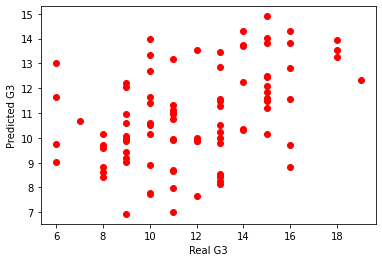

In [32]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, color='r', label='prediction power')
ax.set_xlabel('Real G3')
ax.set_ylabel('Predicted G3')
# ax.legend()
plt.show();

We ccan get a much higher cv score with a really small standard deviation by only using these four features. 

## 5.11 Summary<a id='5.11'></a>

- The overall performance of models is poor.
- G3 is strongly dependent on G1 and G2 (as demonstrated by the heatmap)
- All the other features are weakly related to the G3.
    - One possible reason is the collection of data is less informative. Most of int type data are ordinal, which only exhbits limited correlation with the G3.
- The trained model is not reliable to predict G3 under various conditions as all the recommendations will be disputable.
- A compromised solution would be only using G1, G2, and a few important features to build a reliable model. Then we can generate a reliable model to analze scenarios about how to improve students grade. 